In [1]:
# packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import xarray as xr
from glob import glob

import netCDF4 as nc

# gradient boosting 
from xgboost import XGBRegressor
# random forest
from sklearn.ensemble import RandomForestRegressor
# evaluation metrics
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV



%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

/Users/rosiekrasnoff/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# create an array that includes data at selected single location:
# [date   SWE   temp   humd   airpress]

i = 95 # index for correct lat
j = 206 # index for correct lon
x = 312 # index for correct lat in SWE
y = 160 # index for correct lon in SWE

# open predictor data:
pres_path = '/Users/rosiekrasnoff/Desktop/SWE_final_project/predictor_data/ps_watch-wfdei_2001_2010.nc4'
hum_path = '/Users/rosiekrasnoff/Desktop/SWE_final_project/predictor_data/rhs_watch-wfdei_2001_2010.nc4'
temp_path = '/Users/rosiekrasnoff/Desktop/SWE_final_project/predictor_data/tas_watch-wfdei_2001_2010.nc4'

temp_ds = xr.open_dataset(temp_path) # temperature dataset
humd_ds = xr.open_dataset(hum_path)  # humidity dataset
pres_ds = xr.open_dataset(pres_path) # air pressure dataset

date = pd.DatetimeIndex(temp_ds.time)

#length = (len(temp_ds.time))
#print(length)

train_df = pd.DataFrame(columns=['date','SWE','temp','hum','pres'])
test_df = pd.DataFrame(columns=['date','SWE','temp','hum','pres'])

# loop through time in predictor files, t is time index, one SWE file (may) exist for every day 
for t in range((len(temp_ds.time))):
    
    # date into form yyyymmdd for name of SWE file
    dy = (date.year[t])
    dm = (date.month[t])
    dd = (date.day[t])
    t_date = dy*10000+dm*100+dd 
    str_date = str(t_date)
    
    
    if dm < 6 or dm > 8: # no snow in summer months
        #print(str_date)
        
        # open SWE data if it exists:
        filename = str_date + '_northern_hemisphere_swe_0.25grid.nc'
        swe_path = '/Users/rosiekrasnoff/Desktop/SWE_final_project/GlobSnow_data/' + filename
    
        try: #some SWE files don't exist, so try to open
            swe_ds = xr.open_dataset(swe_path) #swe dataset
            swe_numpy = swe_ds.swe.values #swe values in numpy array
            my_swe = swe_numpy[x,y]
            my_temp = temp_ds.tas[t,i,j].values.item()
            my_humd = humd_ds.hurs[t,i,j].values.item()
            my_pres = pres_ds.ps[t,i,j].values.item()
            #testing data is winter 04-05 or 07-08
            if (dm>8 and dy==2004) or (dm<6 and dy==2005) or (dm>8 and dy==2007) or (dm<6 and dy==2008):
                d = {'date':date[t],'SWE':my_swe,'temp':my_temp,'hum':my_humd,'pres':my_pres}
                test_df = test_df.append(d, ignore_index=True)
            else:               
                d = {'date':date[t],'SWE':my_swe,'temp':my_temp,'hum':my_humd,'pres':my_pres}
                train_df = train_df.append(d, ignore_index=True)
        except:
            pass

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(d, ignore_index=True)
/var/folders/vk/73wdxc_14wj23yn81gyq7zcr0000gn/T/ipykernel_17717/4109801797.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [3]:
# training data
train_df.head()

,date,SWE,temp,hum,pres
0,2001-01-01,0.0,263.546143,73.508492,96964.562500
1,2001-01-02,0.0,262.069763,76.259216,97539.937500
2,2001-01-03,0.0,264.118225,73.916405,97338.460938
3,2001-01-04,0.0,266.926605,69.559303,96404.531250
4,2001-01-05,0.0,266.665710,82.092102,95651.828125


In [4]:
# testing data
test_df.head()

,date,SWE,temp,hum,pres
0,2004-10-10,0.0,282.351868,81.613922,97047.539062
1,2004-10-11,0.0,279.714935,75.211906,97200.710938
2,2004-10-12,0.0,278.931732,75.257233,96695.828125
3,2004-10-13,0.0,281.113586,72.333908,95989.257812
4,2004-10-14,0.0,282.596436,80.060654,95469.359375


In [5]:
# Training data: extracting and converting to arrays


# predictant: SWE
train_SWE_df = train_df[['SWE']]
# convert to 1d array
train_SWE = train_SWE_df.values.ravel()

# predictors: temp, humidity, air pressure
train_data_df = train_df[['temp','hum','pres']]
train_data = train_data_df.values


# Testing data: extracting and converting to arrays
# predictant: SWE
test_SWE_df = test_df[['SWE']]
# convert to 1d array
test_SWE = test_SWE_df.values.ravel()

# predictors: temp, humidity, air pressure
test_data_df = test_df[['temp','hum','pres']]
test_data = test_data_df.values


#print(train_data)

In [6]:
print("Training set: {}".format(train_data_df.shape))  # 1660 days, 3 variables
print("Testing set:  {}".format(test_data_df.shape))   # 426 days, 3 variables

Training set: (1660, 3)
Testing set:  (426, 3)


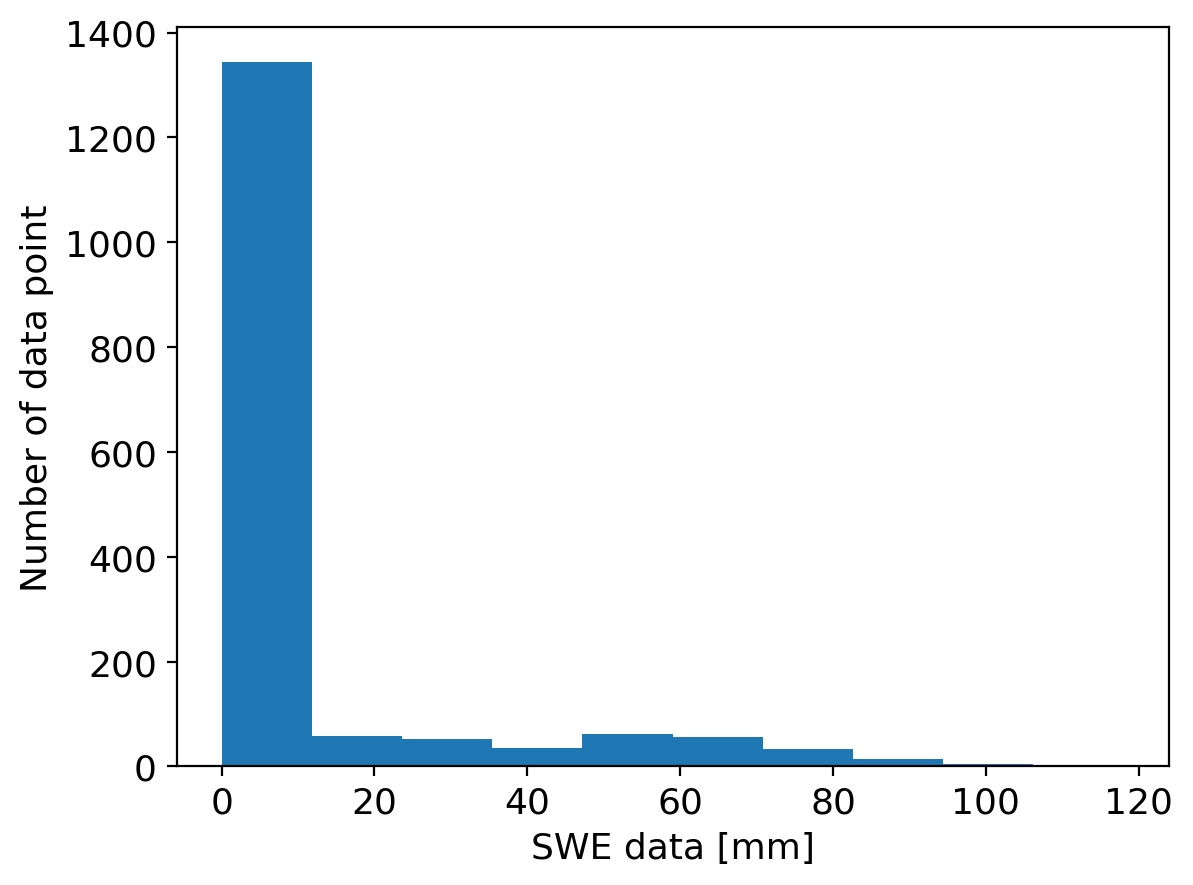

In [7]:
# histogram
SWE = train_SWE
plt.hist(SWE, bins = 10)
plt.xlabel("SWE data [mm]")
plt.ylabel("Number of data point")
plt.show()

### Data normalization

In [8]:
# Standardization
mean, std = train_data_df.mean(), train_data_df.std() # only use the mean and std of the training set

normtrain_data_df   = (train_data_df - mean)/std
normtest_data_df    = (test_data_df - mean)/std

train_data_norm = normtrain_data_df.to_numpy()
test_data_norm = normtest_data_df.to_numpy()

### Define the decision tree methods:

In [30]:
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':2000, #number of trees
              'criterion':'squared_error', # set less
              #'ccp_alpha':0.001,
              'max_depth': 5, #max depth, complexity of tree
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror', #same as MSE, regression
              'n_estimators': 2000,  # number of trees to use
              'learning_rate': 0.001, 
              'max_depth': 5,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,
              'reg_lambda': 0,}

In [36]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
#model = RandomForestRegressor(**params_rfr)
model = XGBRegressor(**params_xgb)

### Train model

In [37]:
%%time
#model.fit(train_data_norm, train_SWE)
model.fit(train_data, train_SWE)



CPU times: user 11 s, sys: 868 ms, total: 11.8 s
Wall time: 1.73 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

test_predictions = model.predict(test_data_norm)
mse = mean_squared_error(test_SWE, test_predictions)
print(f'the mse is {mse}')
from sklearn.metrics import r2_score
r2 = r2_score(test_SWE,test_predictions)
print(f'the R^2 is {r2}')



In [38]:
test_predictions = model.predict(test_data)
mse = mean_squared_error(test_SWE, test_predictions)
print(f'the mse is {mse}')
from sklearn.metrics import r2_score
r2 = r2_score(test_SWE,test_predictions)
print(f'the R^2 is {r2}')



the mse is 255.510233460033
the R^2 is 0.15154196014364074


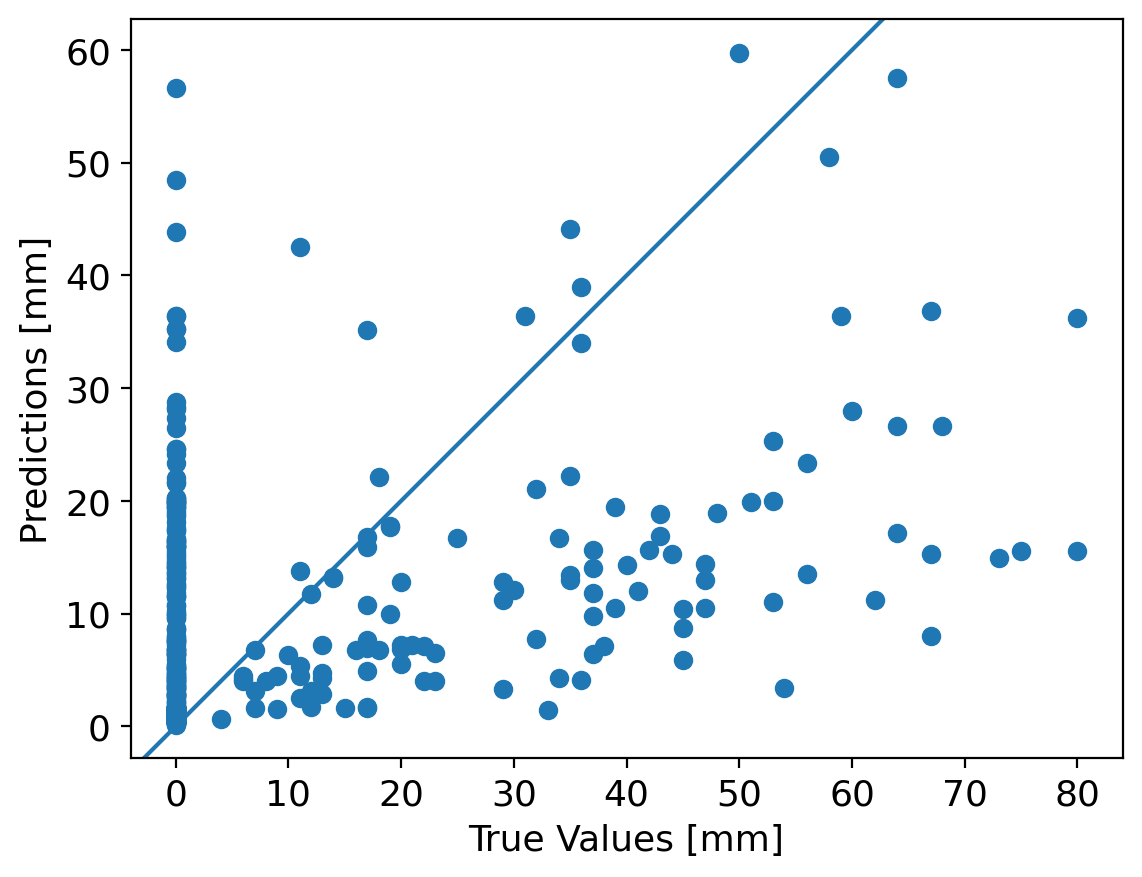

In [39]:

plt.scatter(test_SWE, test_predictions)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

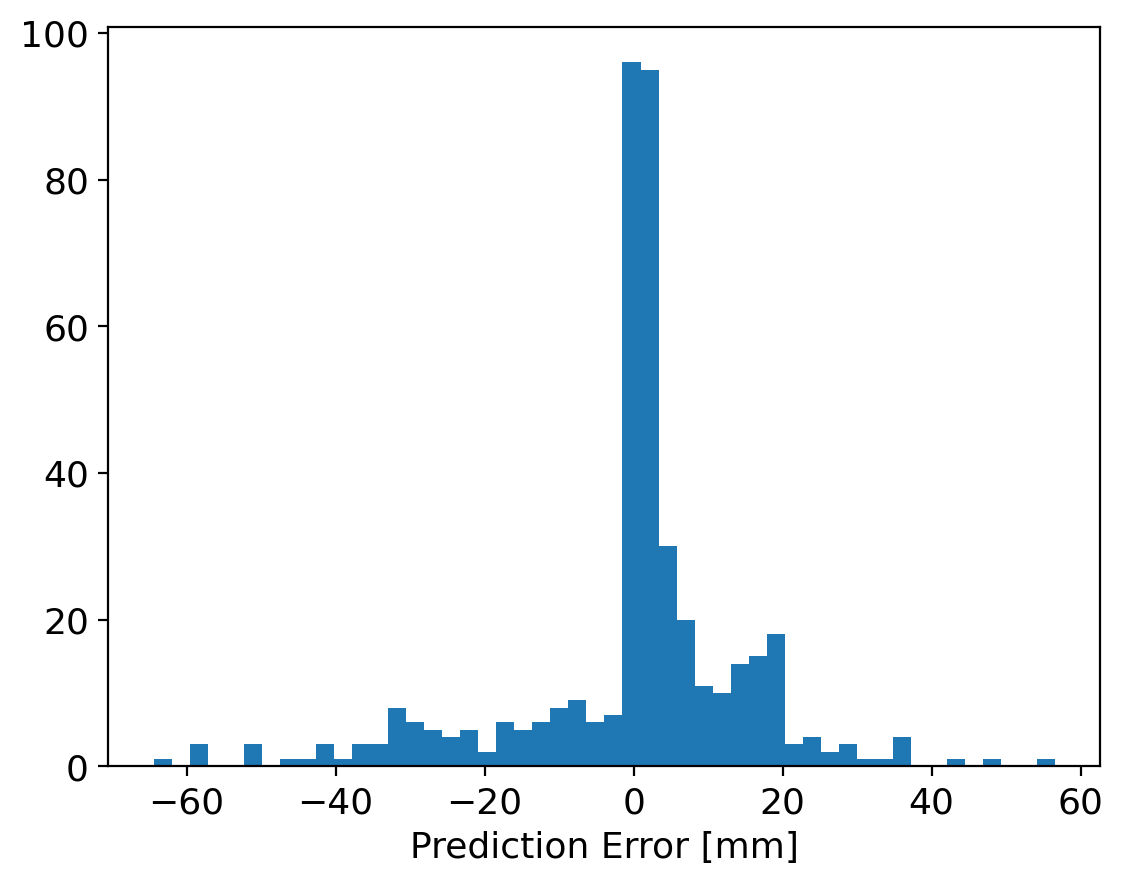

In [40]:
# histogram
error = test_predictions - test_SWE
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mm]")
plt.show()

In [28]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()


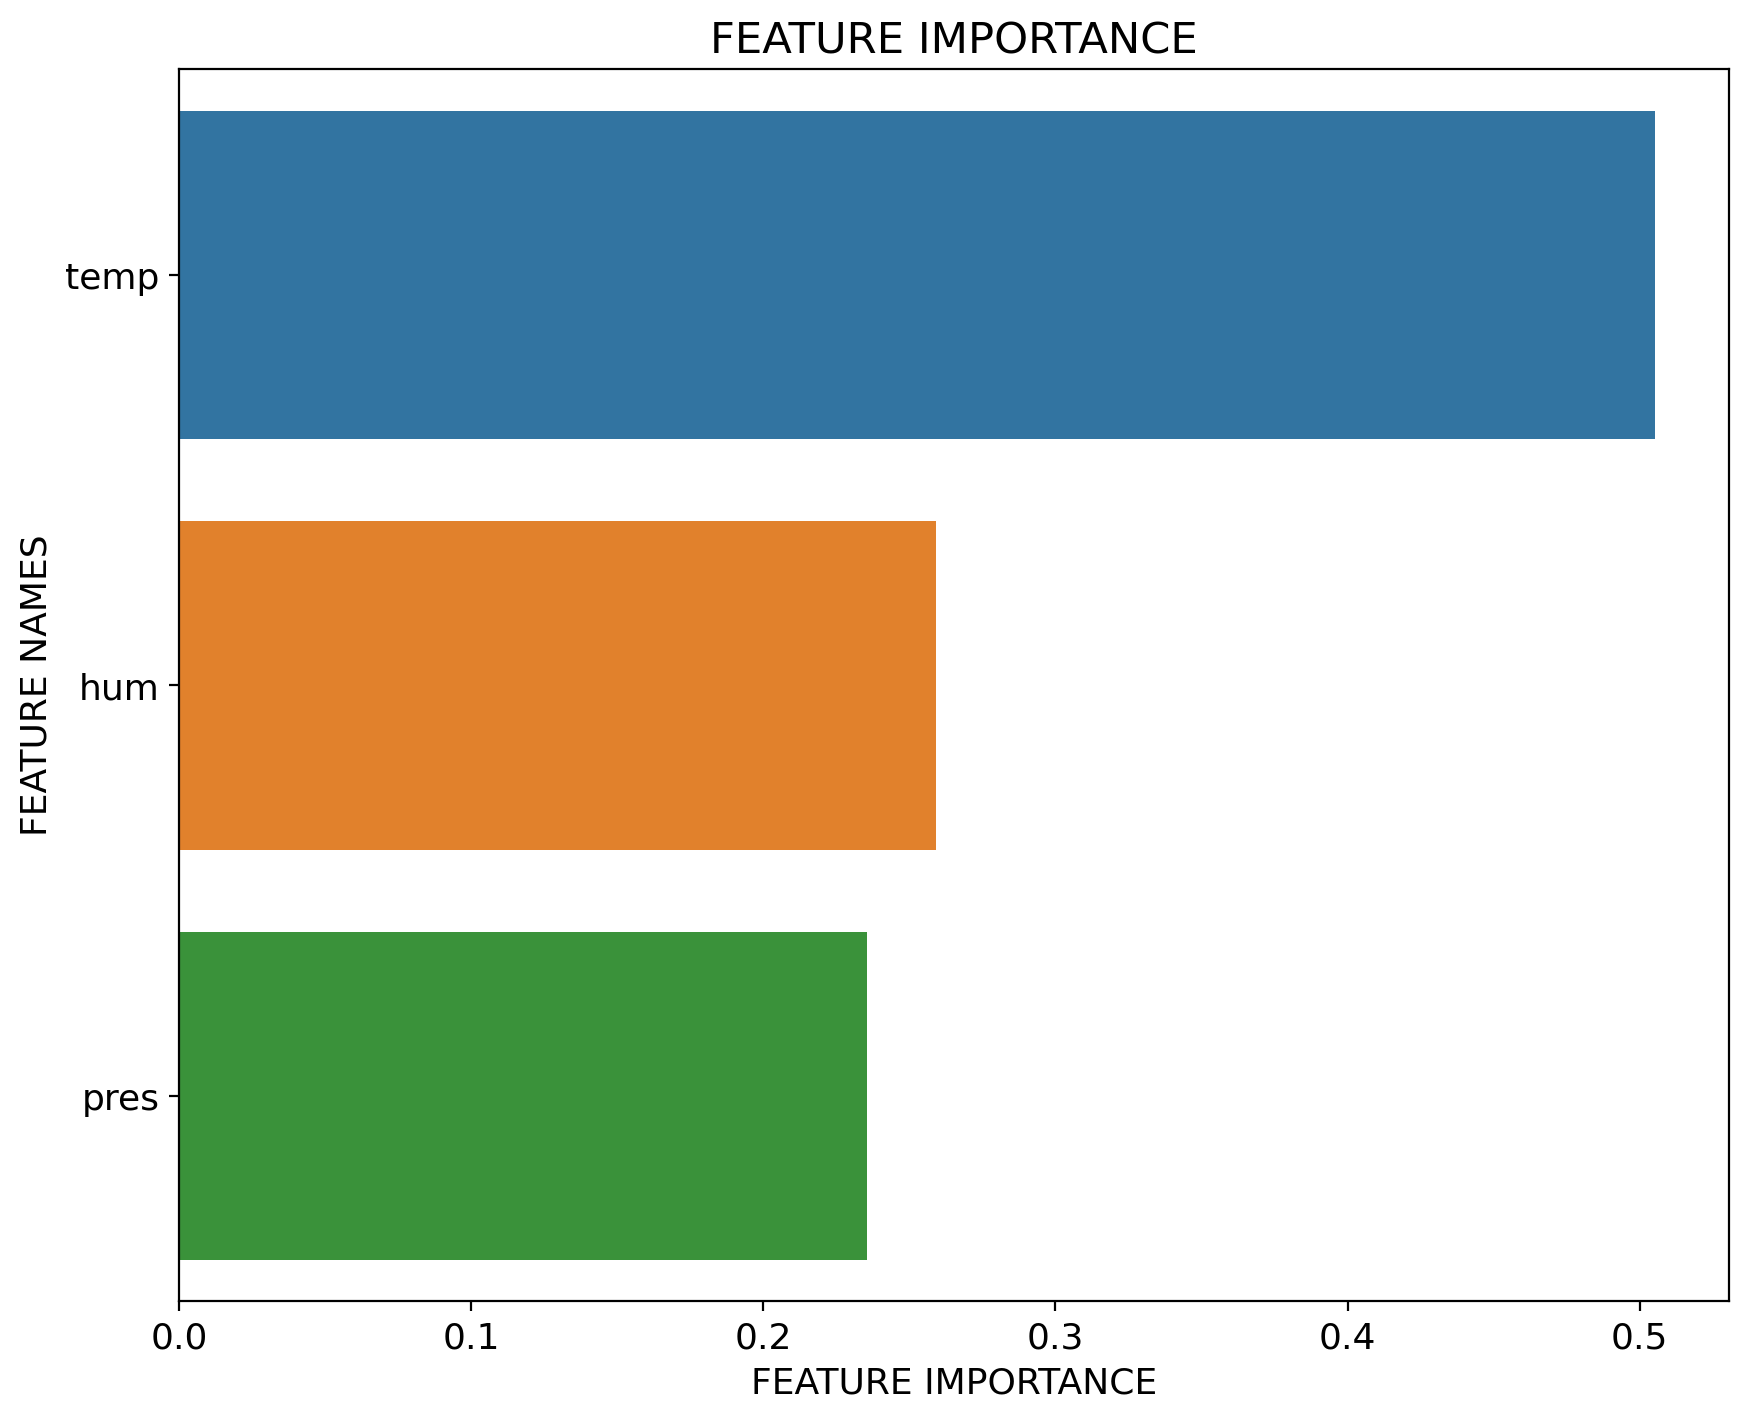

In [29]:
plot_feature_importance(model.feature_importances_, train_data_df.columns)